## AIC lab Experiment RT prediction using DeepLC

In [1]:
! pip install deeplc

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.2/32.2 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 MB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 70.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.5/75.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 18.3 M

In [2]:
from deeplc import DeepLC
import tensorflow as tf
import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

set_matplotlib_formats('svg')


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


We delete peptides with '79.9663' mass modifications because default deeplc does not predict such modifications 

In [3]:
peptides_df = pd.read_csv("/kaggle/input/aic-dataset/tide-index.peptides.txt",sep="\t")
peptides_df = peptides_df[~peptides_df['target'].astype(str).str.contains('79.9663')]
print("The number of rows: %d" % (peptides_df.shape[0]))
peptides_df.head()

The number of rows: 4283907


,target,decoy(s),mass,proteins
0,GGGAGLG,GLGAGGG,487.2390,tr|A0A087WX29|A0A087WX29_HUMAN(237)
1,GGGGGGK,NaN,488.2343,sp|Q9H461|FZD8_HUMAN(211)
2,GGGGGAK,GAGGGGK,502.2499,"tr|K7EQ17|K7EQ17_HUMAN(56),sp|O94818|NOL4_HUMA..."
3,AGGGGGK,NaN,502.2499,sp|P20648|ATP4A_HUMAN(32)
4,GGAGAGQ,GGAGGAQ,516.2292,tr|A0A0D9SES6|A0A0D9SES6_HUMAN(138)


In [4]:
peptides_df.tail()

,target,decoy(s),mass,proteins
38946454,M[15.9949]DHHCPWINNCVGEDNHWLFLQLCFYTELLTCYALM[...,M[15.9949]KLPLFYYYHCFSFM[15.9949]LAYCTLLETYFCL...,6525.9203,sp|Q8IVQ6|ZDH21_HUMAN(116)
38946510,RMDHHCPWINNCVGEDNHWLFLQLCFYTELLTCYALM[15.9949]...,RLPLFYYYHCFSFM[15.9949]LAYCTLLETYFCLQLFLWHNDEG...,6537.9316,sp|Q8IVQ6|ZDH21_HUMAN(115)
38946511,RM[15.9949]DHHCPWINNCVGEDNHWLFLQLCFYTELLTCYALM...,RLPLFYYYHCFSFMLAYCTLLETYFCLQLFLWHNDEGVCNNIWPCH...,6537.9316,sp|Q8IVQ6|ZDH21_HUMAN(115)
38946512,RM[15.9949]DHHCPWINNCVGEDNHWLFLQLCFYTELLTCYALM...,RLPLFYYYHCFSFM[15.9949]LAYCTLLETYFCLQLFLWHNDEG...,6553.9265,sp|Q8IVQ6|ZDH21_HUMAN(115)
38946736,YQRSHDDTTPWERLWFLLLTFTFGLTLTWLYFWWEVHNDYDEFNWY...,YNYLYWNFEDYDNHVEWWFYLWTLTLGFTFTLLLFWLREWPTTDDH...,6596.1224,"sp|Q8WTR4|GDPD5_HUMAN(30),tr|Q8NDN3|Q8NDN3_HUM..."


In [5]:
peptides_df[20000:20020]

,target,decoy(s),mass,proteins
22780,TLTPLGR,TGLPTLR,756.4494,sp|Q96HS1|PGAM5_HUMAN(119)
22781,VINVNAK,VANVNIK,756.4494,sp|P31415|CASQ1_HUMAN(49)
22782,VLGQVNK,VNVQGLK,756.4494,sp|P01031|CO5_HUMAN(1085)
22783,VLNVQGK,VGQVNLK,756.4494,"tr|J3QS41|J3QS41_HUMAN(981),sp|P42694|HELZ_HUM..."
22784,VPIVSSR,VSSVIPR,756.4494,sp|Q14C87|T132D_HUMAN(543)
22785,VTTPAIR,VIAPTTR,756.4494,"tr|A4PB68|A4PB68_HUMAN(431),tr|A0A087WUE6|A0A0..."
22786,LPATSLR,LLSTAPR,756.4494,sp|P58505|CU058_HUMAN(6)
22787,NALNVVK,NVVNLAK,756.4494,"tr|A0A087WYG2|A0A087WYG2_HUMAN(436),sp|Q9UPT6|..."
22788,AINAIQK,AQIANIK,756.4494,"tr|A0A7I2V5C5|A0A7I2V5C5_HUMAN(177),sp|P53634|..."
22789,ANILAQK,AQALINK,756.4494,tr|H7C0S6|H7C0S6_HUMAN(1)


### Modifications

DeepLC expects comma-separated values (CSV) with the following columns:

seq: unmodified peptide sequences
modifications: MS2PIP-style formatted modifications: Every modification is listed as location|name, separated by a pipe (|) between the location, the name, and other modifications. location is an integer counted starting at 1 for the first AA. 0 is reserved for N-terminal modifications, -1 for C-terminal modifications. name has to correspond to a Unimod (PSI-MS) name.
tr: retention time (only required for calibration)

Our dataset contains only Oxidation and Phosphorylation

In [6]:
# Phosphorylation -> 79.9663

# Oxidation -> 15.9949

# PhosphoS,79.966331,S
# PhosphoT,79.966331,T

In [7]:
def replace_substring(input_string):
    s1 = ""
    s2 = []
    in_brackets = False
    current_word = ""
    prev_len = 0

    for i, char in enumerate(input_string):
        if char == "[":
            in_brackets = True
            if current_word:
                s1 += current_word
            current_word = ""
            start_index = i
        elif char == "]":
            in_brackets = False
            end_index = i
            s2.append(str(start_index - prev_len - 1))
            s2.append(input_string[start_index + 1:end_index])
            prev_len += len(input_string[start_index + 1:end_index])
        elif not in_brackets:
            current_word += char

    if current_word:
        s1 += current_word
    s2 = '|'.join(s2)
    s2 = s2.replace('79.9663', 'PhosphoS')  # Phosphorylation
    s2 = s2.replace('15.9949', 'Oxidation')

    return s1, s2


In [8]:
n_splits = 100
p = np.array_split(peptides_df, n_splits)
p1 = p[3]

p1 = p1.where(p1 != 'nan', None)

peptides_df = p1.dropna(subset=['decoy(s)'])

In [9]:
pred_target_data = pd.DataFrame(columns=['seq', 'modifications'])
pred_target_data['seq'], pred_target_data['modifications'] = zip(*peptides_df['target'].apply(replace_substring))
pred_target_data

,seq,modifications
0,GDHWTTR,
1,LFTDFET,
2,FLYSDEV,
3,AGGDLMHR,5|Oxidation
4,DMHGALGR,1|Oxidation
...,...,...
42832,LCLQVLR,
42833,RRGTGLGGK,
42834,VAGKSQRR,
42835,LRDVSRR,


In [10]:
pred_decoy_data = pd.DataFrame(columns=['seq', 'modifications'])
pred_decoy_data['seq'], pred_decoy_data['modifications'] = zip(*peptides_df['decoy(s)'].apply(replace_substring))
pred_decoy_data

,seq,modifications
0,GTTWHDR,
1,LEFDTFT,
2,FEDSYLV,
3,AHMLDGGR,2|Oxidation
4,DGLAGHMR,6|Oxidation
...,...,...
42832,LLVQLCR,
42833,RGGLGTGRK,
42834,VRQSKGAR,
42835,LRSVDRR,


In [11]:
pred_decoy_data[:404703].to_csv('pred_decoy_data.csv', index=None)
pred_target_data[:404703].to_csv('pred_target_data.csv', index=None)

Training

In [12]:
pred_target_data['modifications'] = pred_target_data['modifications'].fillna("")
pred_decoy_data['modifications'] = pred_decoy_data['modifications'].fillna("")

In [13]:
calibration_file = "/kaggle/input/deeplc-dataset/test_train.csv"


cal_df = pd.read_csv(calibration_file, sep=",")
cal_df['modifications'] = cal_df['modifications'].fillna("")

In [14]:
dlc = DeepLC()
dlc.calibrate_preds(seq_df=cal_df)

2/2 [==============================] - 2s 345ms/step


{}

In [15]:
preds_target = dlc.make_preds(seq_df=pred_target_data)

42/42 [==============================] - 46s 1s/step


In [16]:
preds_decoy = dlc.make_preds(seq_df=pred_decoy_data)

42/42 [==============================] - 46s 1s/step


In [17]:
pred_target_data['y'] = preds_target
pred_decoy_data['y'] = preds_decoy

In [18]:
r2 = r2_score(pred_target_data['y'], pred_decoy_data['y'])

print(f"R2 score: {r2}")

R2 score: 0.9625283780251948


In [19]:
diff = abs(pred_target_data['y'] - pred_decoy_data['y'])
print(f"Max difference between target and decoy: {max(diff)};\n Min diff: {min(diff)}")

Max difference between target and decoy: 4185.3893646002525;
 Min diff: 0.0016555446836719057


### Drawing distributions of targets and decoys

In [20]:
# plt.rcParams.update({'font.size': 16})
# sns.set_style('whitegrid')
# np.random.seed(0xFA1AFE1)
%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

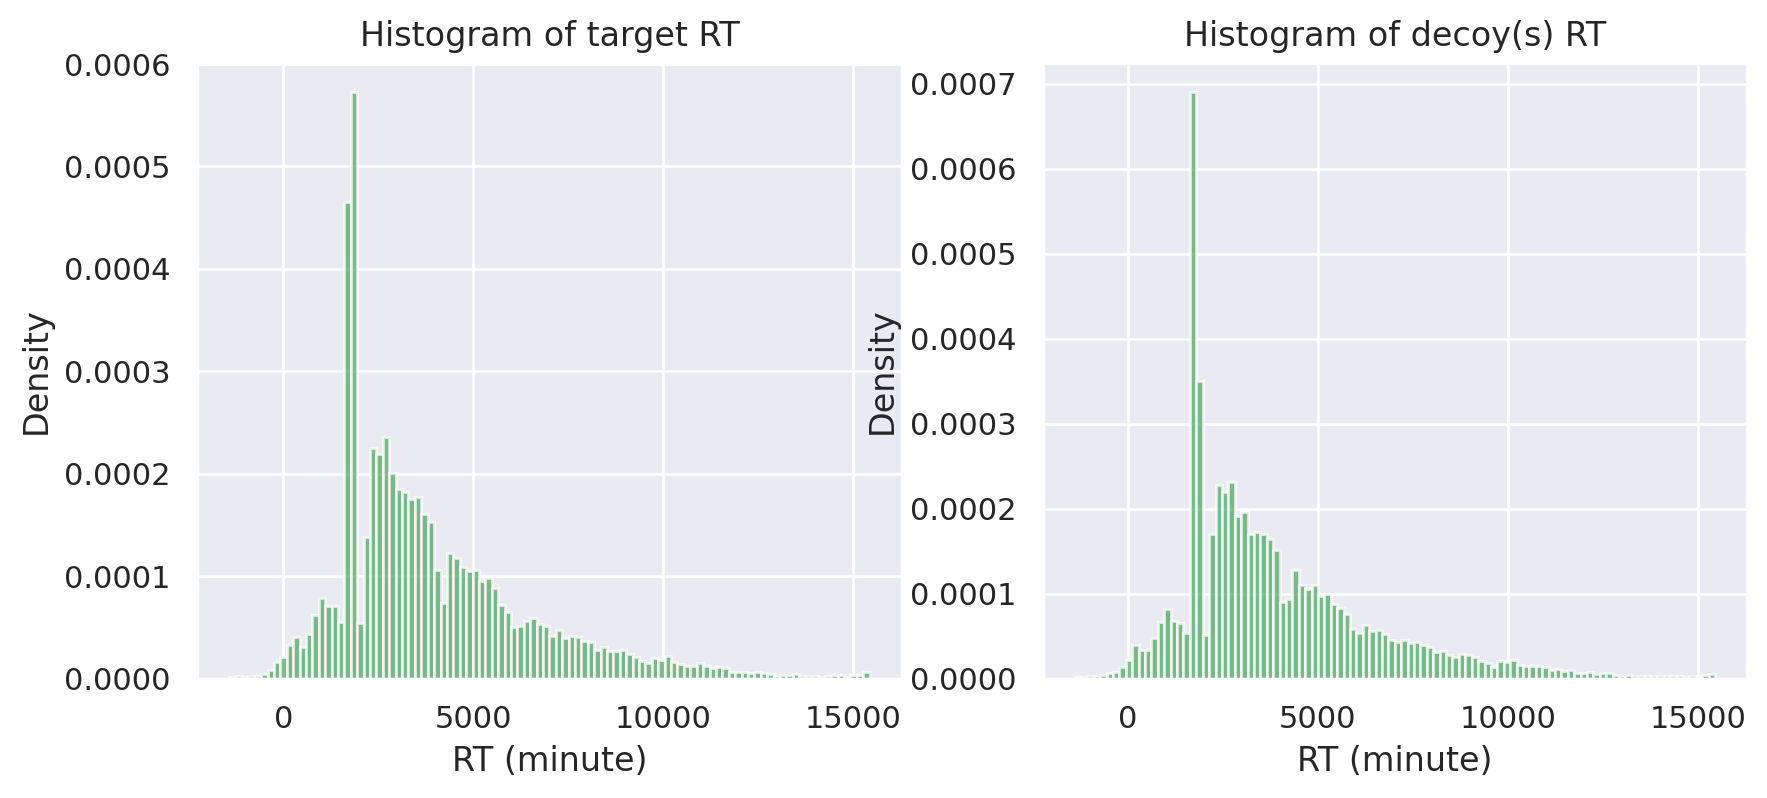

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT')
axes[1].hist(pred_decoy_data['y'], 100, density=True, facecolor='g', alpha=0.75)

# axes[1].xlabel('RT (minute)')
# axes[1].ylabel('Density')
# axes[1].title('Histogram of decoy(s) RT')

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of decoy(s) RT')
plt.grid(True)
plt.show()

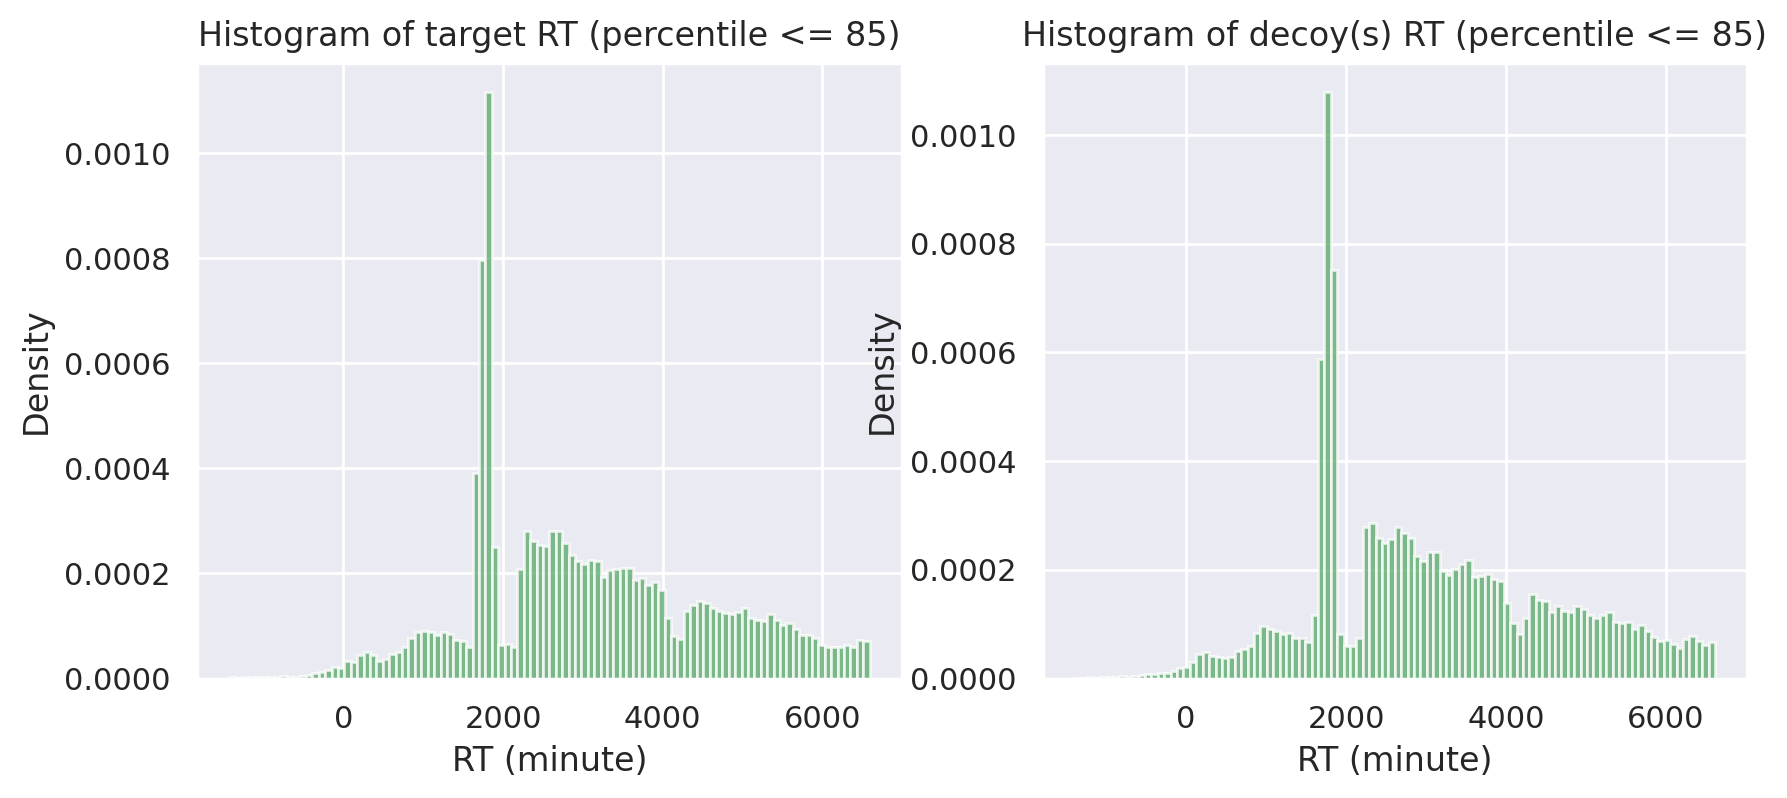

In [22]:
boolean_value1 = pred_target_data['y'].to_numpy() <= np.percentile(pred_target_data['y'].to_numpy(), 85)
boolean_value2 = pred_decoy_data['y'].to_numpy() <= np.percentile(pred_decoy_data['y'].to_numpy(), 85)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data[boolean_value1]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT (percentile <= 85)')
axes[1].hist(pred_decoy_data[boolean_value2]['y'], 100, density=True, facecolor='g', alpha=0.75)

# axes[1].xlabel('RT (minute)')
# axes[1].ylabel('Density')
# axes[1].title('Histogram of decoy(s) RT')

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of decoy(s) RT (percentile <= 85)')
plt.grid(True)
plt.show()

**Code for boxplots**

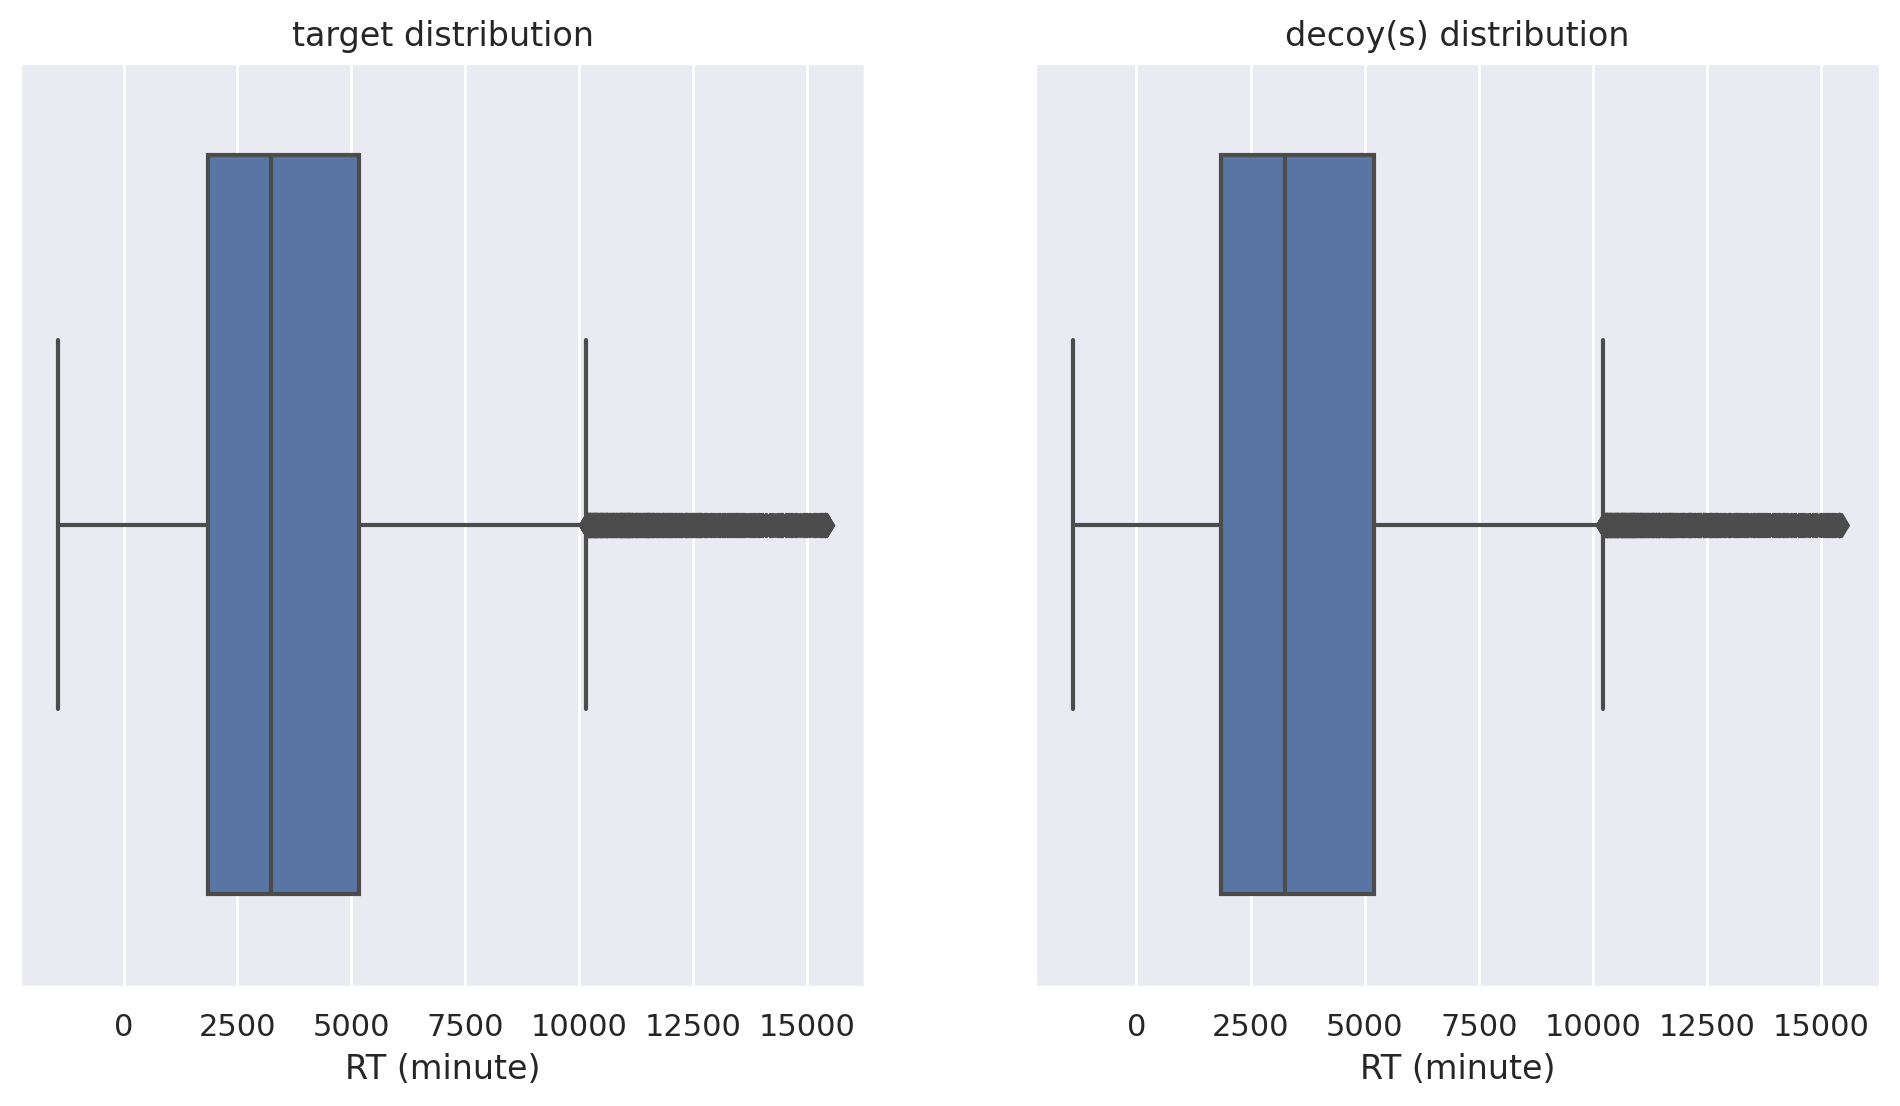

In [23]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=pred_target_data['y'])
plt.xlabel('RT (minute)')
plt.title('target distribution')
plt.subplot(1, 2, 2)
sns.boxplot(x=pred_decoy_data['y'])
plt.title('decoy(s) distribution')
plt.xlabel('RT (minute)')
plt.show()

**And try QQ plot**

In [24]:
df_pct = pd.DataFrame()
df_pct['q_target'] = np.percentile(pred_target_data['y'], range(100))
df_pct['q_decoy(s)'] = np.percentile(pred_decoy_data['y'], range(100))

Text(0.5, 1.0, 'QQ plot')

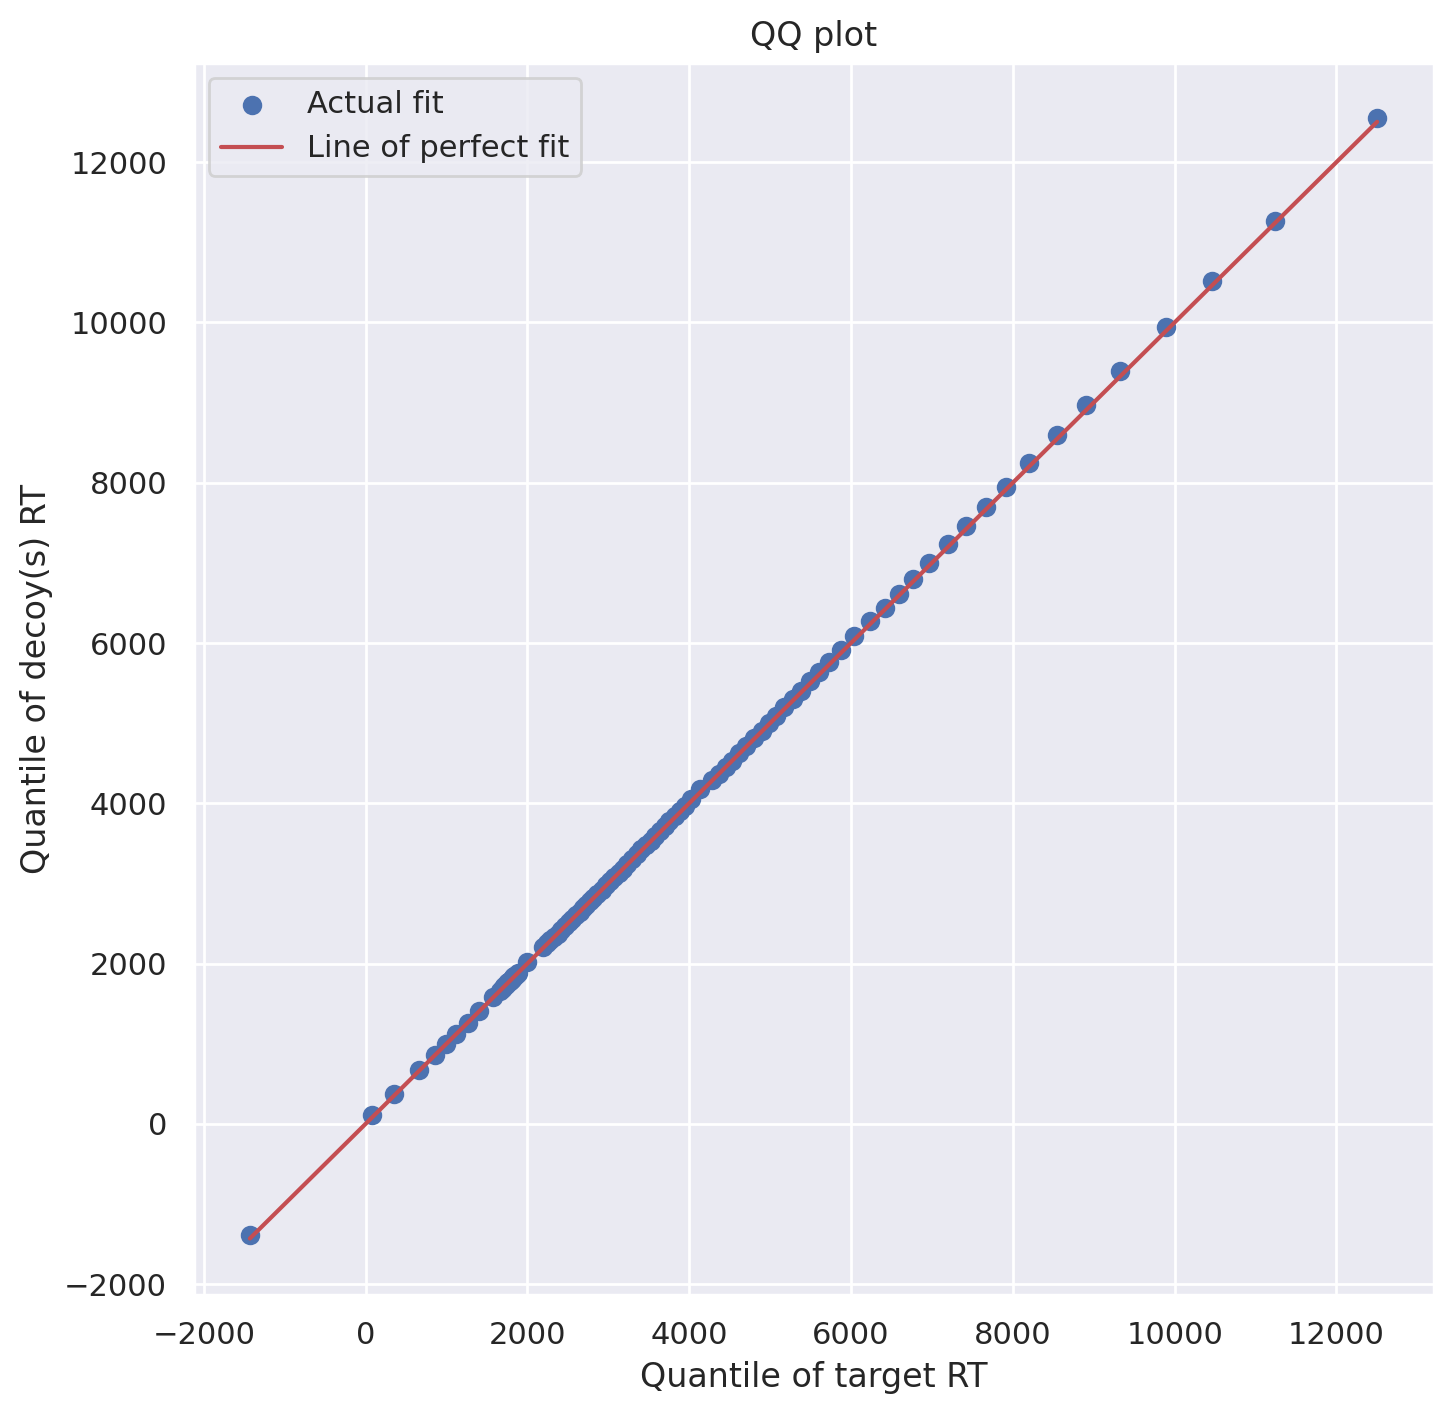

In [25]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_decoy(s)', data=df_pct, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of decoy(s) RT')
plt.legend()
plt.title("QQ plot")

**And look at it`s mini_batch**

In [26]:
target_qq_mini = pred_target_data['y'][10000:20000]
decoy_qq_mini = pred_decoy_data['y'][10000:20000]

In [27]:
df_pct_mini = pd.DataFrame()
df_pct_mini['q_target'] = np.percentile(target_qq_mini, range(100))
df_pct_mini['q_decoy(s)'] = np.percentile(decoy_qq_mini, range(100))

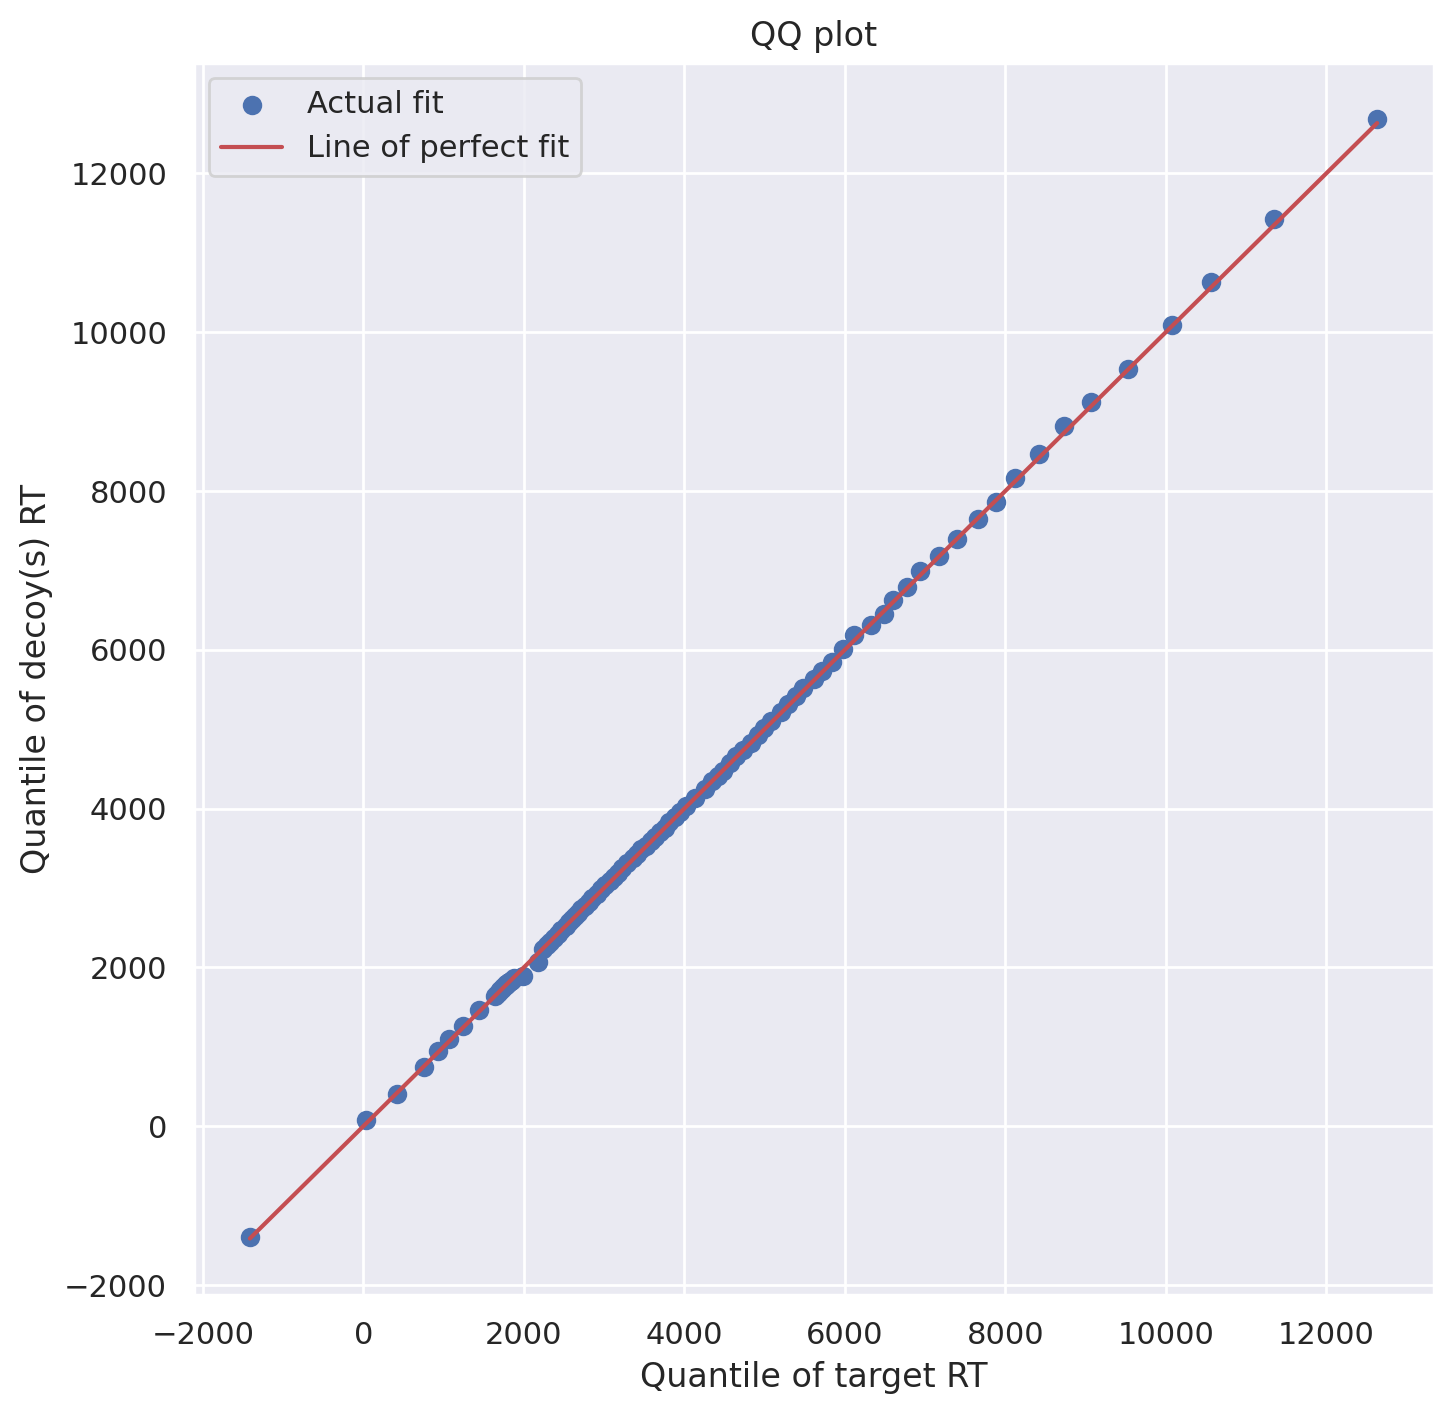

In [28]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_decoy(s)', data=df_pct_mini, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_mini, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of decoy(s) RT')
plt.legend()
plt.title("QQ plot");

**One more plot to analyze - roc curve**

In [29]:
def plot_auc(dstr1, dstr2):
    # Creating class labels for two distributions (0 - distribution1, 1 - distribution2)
    labels = np.concatenate([np.zeros(len(dstr1)), np.ones(len(dstr2))])

    # We construct the ROC curve and calculate its AUC
    fpr, tpr, _ = metrics.roc_curve(labels, np.concatenate([dstr1, dstr2]))
    roc_auc = metrics.auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [30]:
target_distribution = pred_target_data['y']
decoy_distribution = pred_decoy_data['y']

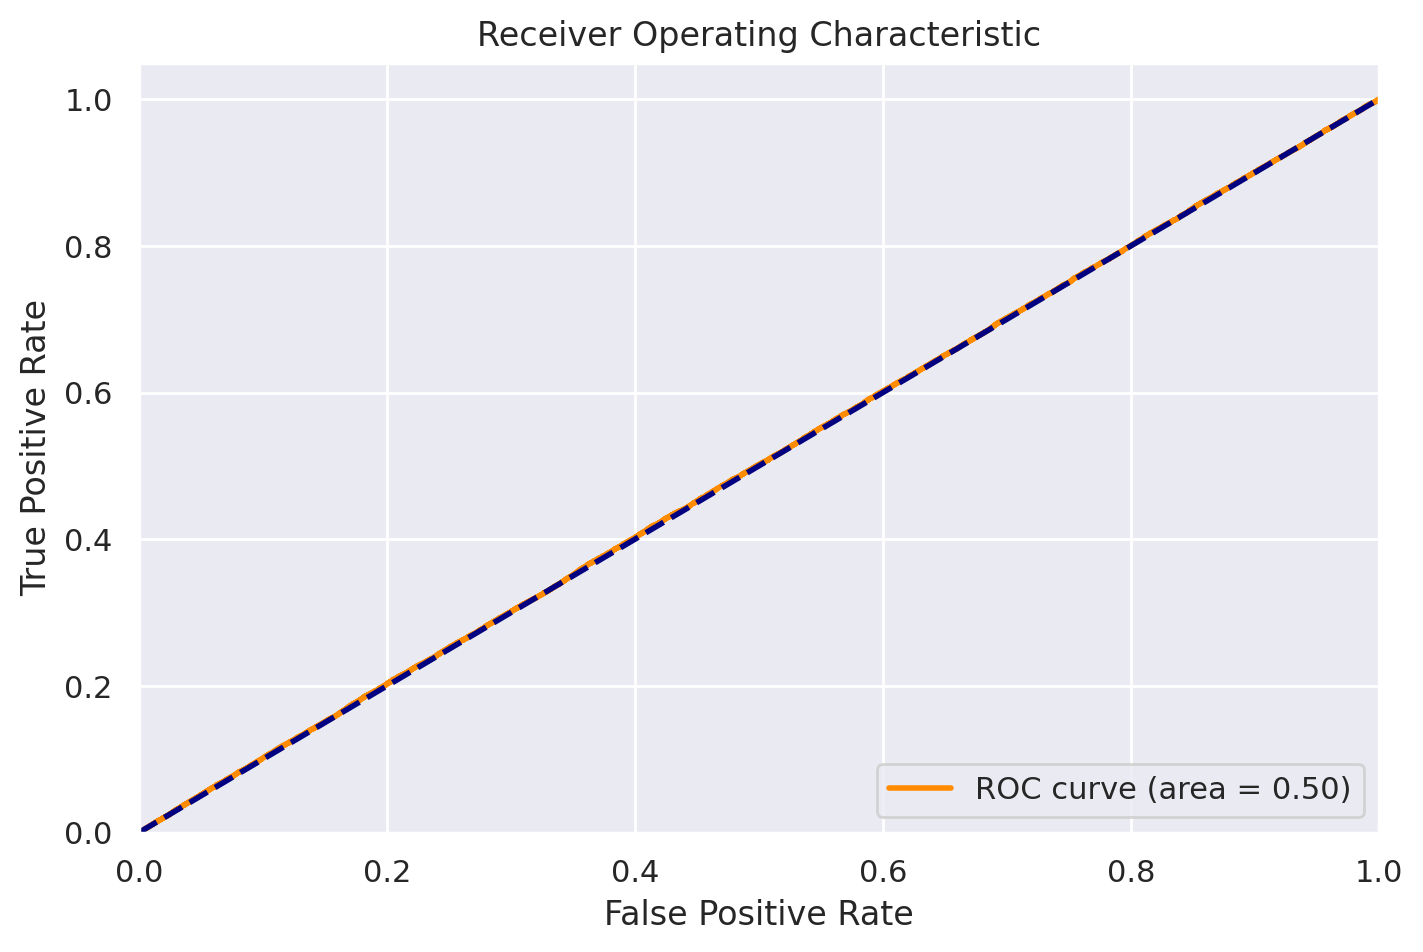

In [31]:
plot_auc(target_distribution, decoy_distribution)

Looking at mini_batch

In [32]:
target_distribution_mini = pred_target_data['y'][10000:20000]
decoy_distribution_mini = pred_decoy_data['y'][10000:20000]

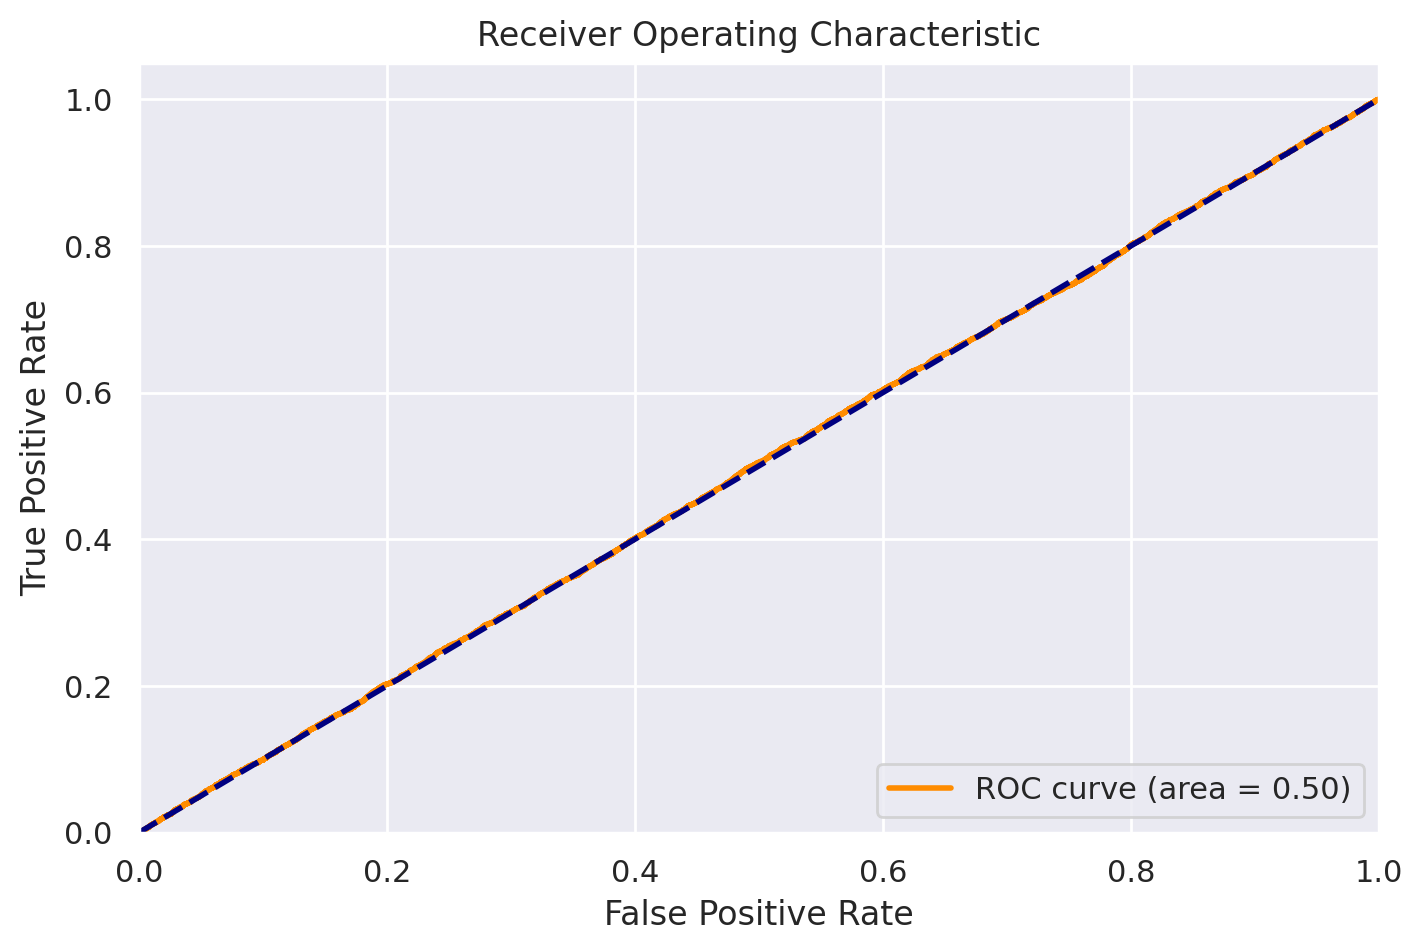

In [33]:
plot_auc(target_distribution_mini, decoy_distribution_mini)

### The next experiment is shuffle

In [34]:
def shuffle_string(text):
    parts = []
    i = 0
    middle_str = text[1:-1]
    while i < len(middle_str):
        if middle_str[i] == '[':
            end = middle_str.find(']', i)
            parts.append(middle_str[i:end+1])
            i = end + 1
        else:
            parts.append(middle_str[i])
            i += 1

    random.shuffle(parts)
    return text[0] + ''.join(parts) + text[-1]

**Constracting DataFrame**

Cells below are empty because of the memory limit, however it can work on your device, so we do not delete them

In [35]:
peptides_df['shuffled_decoy(s)'] = peptides_df['decoy(s)'].apply(shuffle_string)
peptides_df['shuffled_decoy(s)']

In [ ]:
pred_shuffled_decoy_data = pd.DataFrame(columns=['seq', 'modifications'])
pred_shuffled_decoy_data['seq'], pred_shuffled_decoy_data['modifications'] = zip(*peptides_df['shuffled_decoy(s)'].apply(replace_substring))
pred_shuffled_decoy_data

In [ ]:
preds_shuffled_decoy = dlc.make_preds(seq_df=pred_shuffled_decoy_data)
pred_shuffled_decoy_data['y'] = preds_shuffled_decoy
pred_shuffled_decoy_data

In [ ]:
r2 = r2_score(pred_target_data['y'], pred_shuffled_decoy_data['y'])

print(f"R2 score: {r2}")

In [ ]:
diff = abs(pred_target_data['y'] - pred_shuffled_decoy_data['y'])
print(f"Max difference between target and decoy: {max(diff)};\n Min diff: {min(diff)}")

**Drawing plots**

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT')
axes[1].hist(pred_shuffled_decoy_data['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of shuffled decoy(s) RT')
plt.grid(True)
plt.show()

histograms with percentile <= 85

In [ ]:
boolean_value1 = pred_target_data['y'].to_numpy() <= np.percentile(pred_target_data['y'].to_numpy(), 85)
boolean_value2 = pred_shuffled_decoy_data['y'].to_numpy() <= np.percentile(pred_shuffled_decoy_data['y'].to_numpy(), 85)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].hist(pred_target_data[boolean_value1]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[0].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of target RT (percentile <= 85)')
axes[1].hist(pred_shuffled_decoy_data[boolean_value2]['y'], 100, density=True, facecolor='g', alpha=0.75)

axes[1].set(ylabel='Density', xlabel='RT (minute)', title='Histogram of shuffled decoy(s) RT (percentile <= 85)')
plt.grid(True)
plt.show()

**boxplots**

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.subplots(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x=pred_target_data['y'])
plt.xlabel('RT (minute)')
plt.title('target distribution')
plt.subplot(1, 2, 2)
sns.boxplot(x=pred_shuffled_decoy_data['y'])
plt.title('shuffled decoy(s) distribution')
plt.xlabel('RT (minute)')
plt.show()

**QQ plot**

In [ ]:
df_pct_shuffled = pd.DataFrame()
df_pct_shuffled['q_target'] = np.percentile(pred_target_data['y'], range(100))
df_pct_shuffled['q_shuffled_decoy(s)'] = np.percentile(pred_shuffled_decoy_data['y'], range(100))

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_shuffled_decoy(s)', data=df_pct_shuffled, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_shuffled, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of shuffled decoy(s) RT')
plt.legend()
plt.title("QQ plot");

It`s mini_batch

In [ ]:
df_pct_shuffled_mini = pd.DataFrame()
df_pct_shuffled_mini['q_target'] = np.percentile(pred_target_data['y'][10000:20000], range(100))
df_pct_shuffled_mini['q_shuffled_decoy(s)'] = np.percentile(pred_shuffled_decoy_data['y'][10000:20000], range(100))

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(x='q_target', y='q_shuffled_decoy(s)', data=df_pct_shuffled_mini, label='Actual fit');
sns.lineplot(x='q_target', y='q_target', data=df_pct_shuffled_mini, color='r', label='Line of perfect fit');
plt.xlabel('Quantile of target RT')
plt.ylabel('Quantile of shuffled decoy(s) RT')
plt.legend()
plt.title("QQ plot");

**AUC-ROC**

In [ ]:
distribution_shuffled = pred_shuffled_decoy_data['y']

In [ ]:
plot_auc(target_distribution, distribution_shuffled)

It`s mini_batch

In [ ]:
distribution_shuffled_mini = pred_shuffled_decoy_data['y'][10000:20000]

In [ ]:
plot_auc(target_distribution_mini, distribution_shuffled_mini)